In [1]:
import requests
import json
import os
import pandas as pd
import datetime
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from IPython.display import JSON
import ast
import scipy.stats as stats
from matplotlib.colors import ListedColormap

# Time seriese similarity
In addition to smoothing, it will be usefull to understand the similarity between a lot of these various tag measures over time. How do tags coorilate between eachother. What tags are coorilated, which are not?

In [2]:
# Break down by tags
tag_representation =  pd.read_csv( "./youtube_data/tag_view.csv" )
tag_representation = tag_representation[['date', 'tag', 'weight', 'vid', 'channel']].set_index('date')
tag_representation.index = pd.to_datetime(tag_representation.index)

tag_representation

,tag,weight,vid,channel
date,,,,
2018-11-16,personalfinance,389,mQMkBhl6zFo,40 Finance
2018-11-16,techstocks,389,mQMkBhl6zFo,40 Finance
2018-11-16,financialplanning,389,mQMkBhl6zFo,40 Finance
2018-11-25,stockmarket,177,4u62lRmWlq8,40 Finance
2018-11-25,investing,177,4u62lRmWlq8,40 Finance
...,...,...,...,...
2020-12-02,whenaredividendspaidout,2517,fA_pAI3YFig,Honest Finance
2020-12-02,whenaredividendsissued,2517,fA_pAI3YFig,Honest Finance
2020-12-02,stockmarketinvesting,2517,fA_pAI3YFig,Honest Finance


In [3]:
# Broken down by day
daily_weight = pd.read_csv( "./youtube_data/daily_weight.csv" )
daily_weight.columns = ['date', 'vids', 'weight', 'ave']
daily_weight = daily_weight.set_index('date')
daily_weight.index = pd.to_datetime(daily_weight.index)
daily_weight

,vids,weight,ave
date,,,
2016-03-26,22.0,203764.0,9262.000000
2016-03-27,22.0,203764.0,9262.000000
2016-03-28,22.0,203764.0,9262.000000
2016-03-29,22.0,203764.0,9262.000000
2016-03-30,22.0,203764.0,9262.000000
...,...,...,...
2020-12-06,548.0,52314373.0,95464.184307
2020-12-07,1026.0,178967634.0,174432.391813
2020-12-08,1530.0,145633909.0,95185.561438


In [4]:
# From SKEW
def fill_empty_dates (df):
    dates = pd.date_range(df.index.min(), df.index.max())
    return df.reindex(dates)
def clamp_dates (df, start='2017-01-01', end='2020-12-05'):
    dates = pd.date_range(start, end)
    return df.reindex(dates)
def dual_rolling_smooth ( data, d = 5 ):
    return scale ( 
        pd.Series(data)
            .rolling(d).mean()[::-1]
            .rolling(d).mean()[::-1]
            .rolling(d*2).mean()[::-1]
            .rolling(d*2).mean()[::-1]
    )
# Scale all the data so it is between 0 and 1
def scale ( data ):
    return (data - data.min()) / ( data.max() - data.min() )

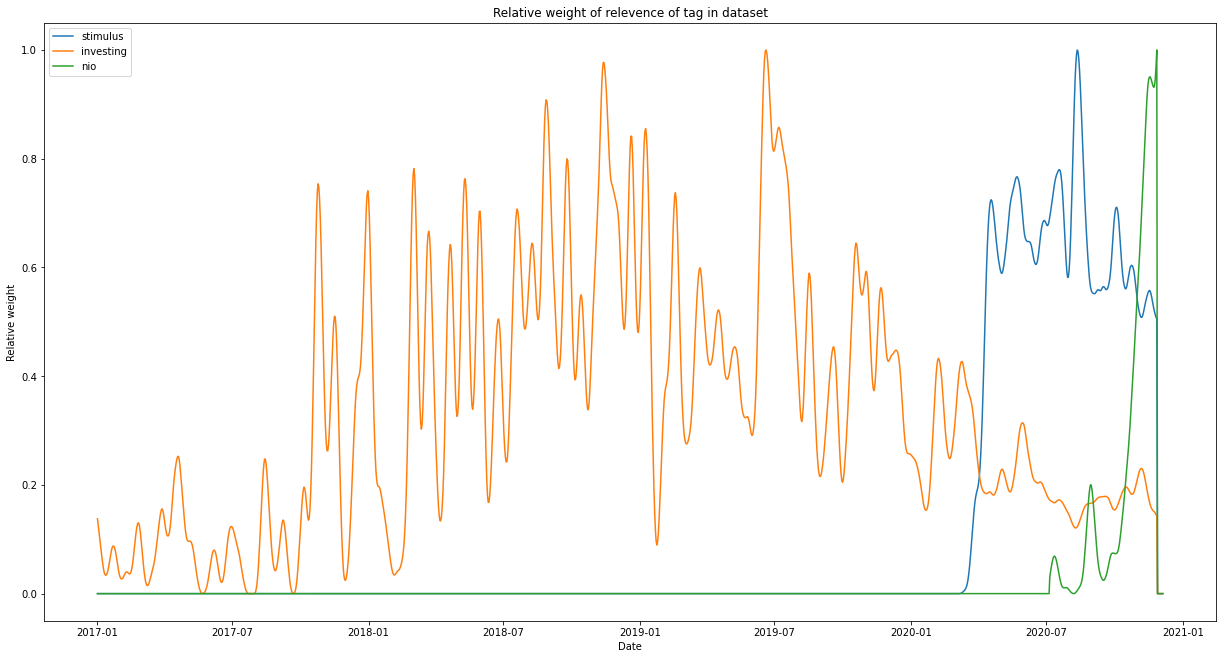

In [5]:
# First, lets use the smoothing data we established before to look at a few tags over time
def get_performance ( _tag, start='2017-01-01', end='2020-12-05'):
    tag = _tag
    tag = tag_representation[ tag_representation.tag == tag ].groupby('date').sum().sort_index()
    tag = fill_empty_dates( tag ).fillna(0)
    tag['total_weight'] = daily_weight['weight']
    tag['share_of_weight'] = tag['weight'] / tag['total_weight']
    tag['smoothed_weight'] = dual_rolling_smooth( tag['share_of_weight'], d=5 )
    tag = clamp_dates(tag.dropna(), start = start, end=end).fillna(0)
    return tag['smoothed_weight']
    
# Graph it out
fig, ax = plt.subplots()
ax.plot( get_performance( 'stimulus' ) , label='stimulus')
ax.plot( get_performance( 'investing' ) , label='investing')
ax.plot( get_performance( 'nio' ) , label='nio')
ax.set(title='Relative weight of relevence of tag in dataset', ylabel='Relative weight', xlabel='Date')
ax.legend()
fig.set_size_inches(21,11)

Since this graph scales each stock to set 1 as its highest popularity and 0 as its least popular its not ment to judge absolute performance, but it shows in a good way how stocks are swinging reletive to one another.

Using the smoothing we did earlier, we can now see the reletive performance of some of the tags from the dataset. We can clearly see that tags have their own individual trends over time as they gain and loose popularity in the dataset. 'Stimulus' for example is clearly been only relevant recently and remains important. Where-as general 'investing' seems to be on the decline since its highs in 2019. Its interesting to see how various tags coorilate with eachother. 'Nio' is a hot new electric vehicle stock that has seen an explosion of interest recently, and the graph clearly hels visualize that.

Given that we can create these graphs for each tag, it should be possible to run some clustering algorithms to provide an idea of what tags are coorilating with eachother.

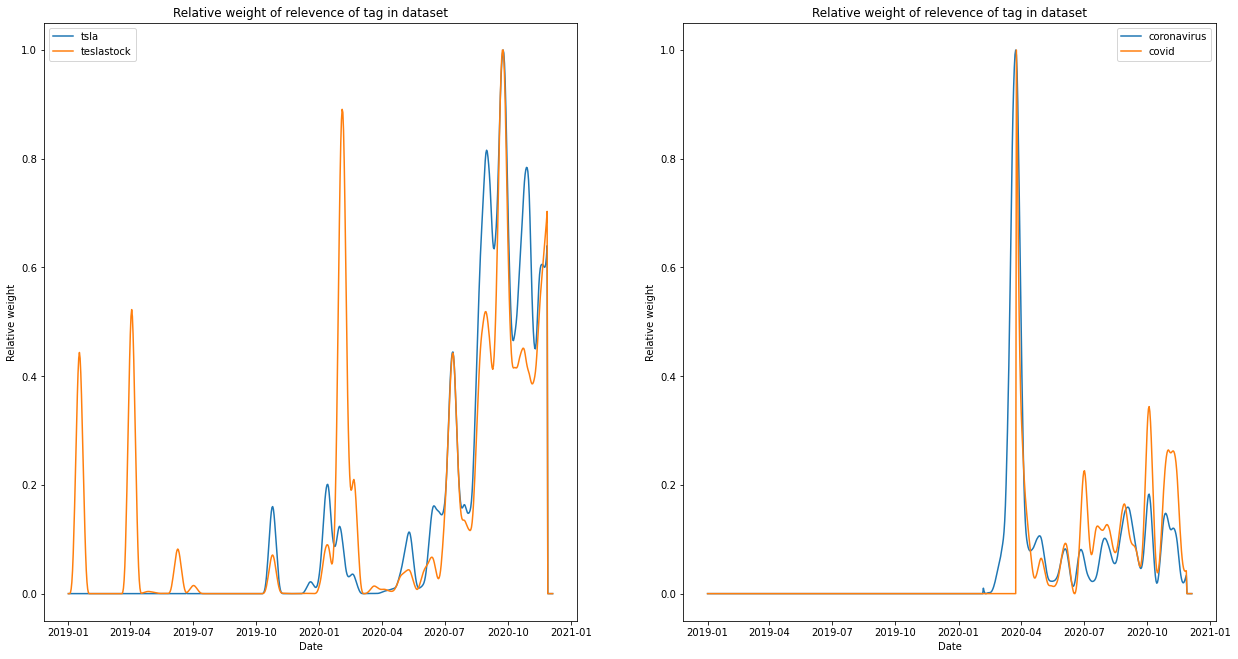

In [6]:
# First we must provide a measure for similarity between two tags given
# For example, the below tags should have a good coorilation as they are clearly quite similer performance minus a few discrepensies

a = get_performance( 'tsla' , start='2019-01-01')
b = get_performance( 'teslastock', start='2019-01-01' )
c = get_performance( 'coronavirus' , start='2019-01-01')
d = get_performance( 'covid', start='2019-01-01' )


# Plot them
fig, ax = plt.subplots(1,2)
ax[0].plot( a , label='tsla')
ax[0].plot( b , label='teslastock')
ax[0].set(title='Relative weight of relevence of tag in dataset', ylabel='Relative weight', xlabel='Date')
ax[0].legend()
ax[1].plot( c , label='coronavirus')
ax[1].plot( d , label='covid')
ax[1].set(title='Relative weight of relevence of tag in dataset', ylabel='Relative weight', xlabel='Date')
ax[1].legend()
fig.set_size_inches(21,11)

In [7]:
a[a>0].index[0]

Timestamp('2019-06-22 00:00:00')

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


,tsla,teslastock,coronavirus,covid
tsla,1.000000,0.893858,0.058636,0.044364
teslastock,0.893858,1.000000,0.042271,0.038041
coronavirus,0.058636,0.042271,1.000000,0.778414
covid,0.044364,0.038041,0.778414,1.000000


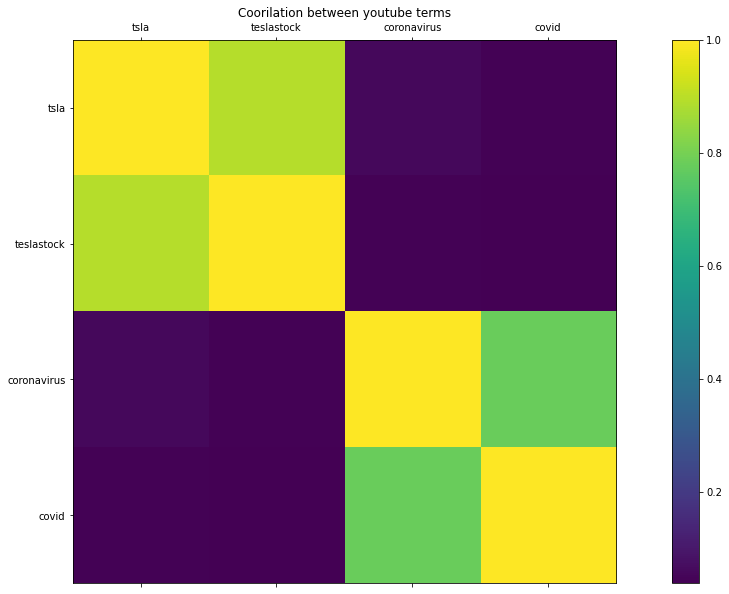

In [8]:
# Below are a few aproaches
_labels = ['tsla','teslastock','coronavirus','covid']
_tags = [a,b,c,d]
results = []

for tag1 in _tags:
    row = []
    for tag2 in _tags:
        first = max( tag1[tag1>0].index[0], tag2[tag2>0].index[0] )
        _a = tag1[tag1.index >= first ].diff().dropna()
        _b = tag2[tag2.index >= first ].diff().dropna()
        row.append(stats.pearsonr(_a,_b)[0])
    results.append(row)
    
results = pd.DataFrame( results )
results.columns = _labels
results.index = _labels

fig, ax = plt.subplots(1,1)
fig.colorbar( ax.matshow(results) )
ax.set_xticklabels(['']+_labels)
ax.set_yticklabels(['']+_labels)
plt.title('Coorilation between youtube terms')
fig.set_size_inches(20,10)

results


In [9]:
top_1000_tags = tag_representation.groupby('tag').sum().sort_values('weight', ascending=False)[:100].index.values
top_1000_tags[:5]

array(['stimuluscheck', 'stimuluschecks', 'stimuluspackage', 'investing',
       'howtoinvest'], dtype=object)

In [10]:
# Get performances
tag_scores = [
    get_performance( tag )
    for tag in top_1000_tags
]

In [11]:
top_1000_tags

array(['stimuluscheck', 'stimuluschecks', 'stimuluspackage', 'investing',
       'howtoinvest', 'stimulus', 'passiveincome', 'howtoinvestinstocks',
       'investingforbeginners', 'stimulusbill', 'howtoinvestinrealestate',
       'secondstimuluscheck', 'stimulusupdate', 'secondstimulus',
       'stimuluscheckupdate', 'robinhood', 'realestateinvesting',
       'robinhoodapp', 'realestate', 'stockmarket',
       'stimulusunemployment', 'ndstimuluscheck', 'howtobeamillionaire',
       'howtobuildwealth', 'stimuluscheckround', 'stockmarketinvesting',
       'trump', 'creditscore', 'stimuluscheckstatus',
       'unemploymentstimulus', 'stocks', 'news', 'secondstimulusupdates',
       'creditscoreexplained', 'investinginyours', 'stimuluschecksecond',
       'secondstimuluscheckupdate', 'creditcard', 'caresact', 'ppploan',
       'beststocktradingapp', 'stimuluschecknews', 'heroesact',
       'stockmarketinvestingforbeginners', 'howtobeamillionaireinyears',
       'money', 'whensecondstimulus

In [13]:
# Lets make check coorilation

results = []
for i,tag1 in enumerate(top_1000_tags):
    print(f"{i}/{len(top_1000_tags)} {tag1}".rjust(100,' '), end='\r')
    row = []
    for j,tag2 in enumerate(top_1000_tags):
        if j < i : row.append(np.nan)
        elif j==i : row.append(np.nan)
        else:
            _1 = tag_scores[i]
            _2 = tag_scores[j]
            first = max( _1[_1>0].index[0], _2[_2>0].index[0] )
            _1 = _1[_1.index >= first ].diff().dropna()
            _2 = _2[_2.index >= first ].diff().dropna()
            row.append(stats.pearsonr(_1,_2)[0])
    results.append(row)

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.con

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.con

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.con

C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
C:\Users\Eric Robertson\.conda\envs\data_science\lib\site-packages\ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


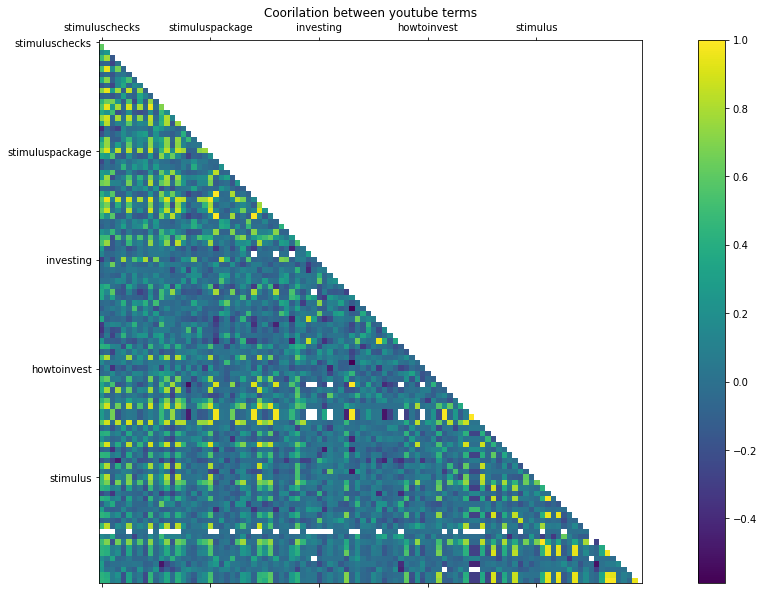

In [14]:
result_table = pd.DataFrame( results ).T
result_table.columns = top_1000_tags
result_table.index = top_1000_tags

fig, ax = plt.subplots(1,1)
fig.colorbar( ax.matshow(result_table) )
ax.set_xticklabels(['']+top_1000_tags)
ax.set_yticklabels(['']+top_1000_tags)
plt.title('Coorilation between youtube terms')
fig.set_size_inches(20,10)


In [15]:
# Highest coorilations
coorilations = result_table.stack().reset_index().sort_values(0, ascending=False)
coorilations

,level_0,level_1,0
2395,newstodayusa,newstodaylive,1.000000
1992,stimulustalks,whensecondstimuluscheck,0.999876
399,stimuluscheckstatus,ndstimuluscheck,0.998171
517,secondstimulusupdates,ndstimuluscheck,0.994896
524,secondstimulusupdates,stimuluscheckstatus,0.993268
...,...,...,...
4512,taxes,secondstimuluscheck,-0.494158
4592,taxes,willtherebeasecondstimuluscheck,-0.511089
1965,stimulustalks,realestateinvesting,-0.530034
1218,passiveincomeideas,whensecondstimuluscheck,-0.578244


In [16]:
def compair_tags (a,b):
    
    _a = get_performance( a )
    _b = get_performance( b )

    first = max( _a[_a>0].index[0], _b[_b>0].index[0] )
    _a = _a[_a.index >= first ]
    _b = _b[_b.index >= first ]
    
    fig, ax = plt.subplots(1,1)
    ax.plot( _a , label=a)
    ax.plot( _b , label=b)
    ax.set(title='Relative weight of relevence of tag in dataset', ylabel='Relative weight', xlabel='Date')
    ax.legend()

    fig.set_size_inches(11,11)

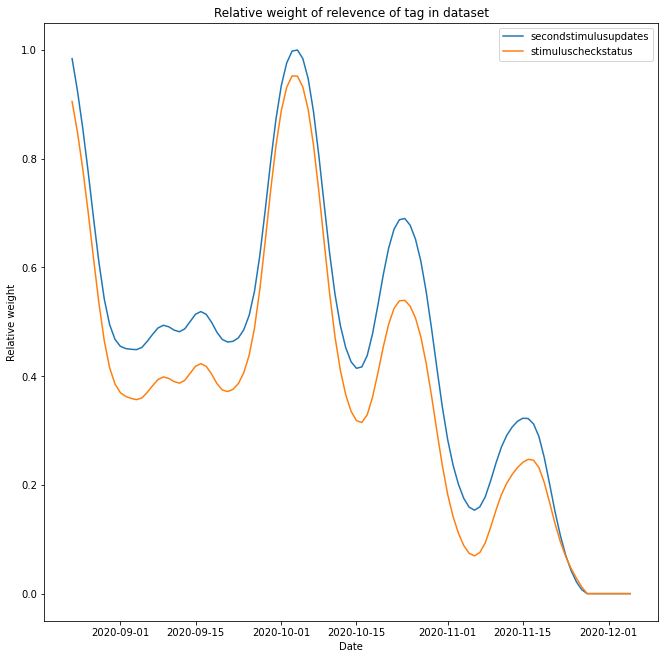

In [17]:
# passiveincomeideas vs whensecondstimuluscheck shows terrible coorilation
compair_tags('secondstimulusupdates', 'stimuluscheckstatus')

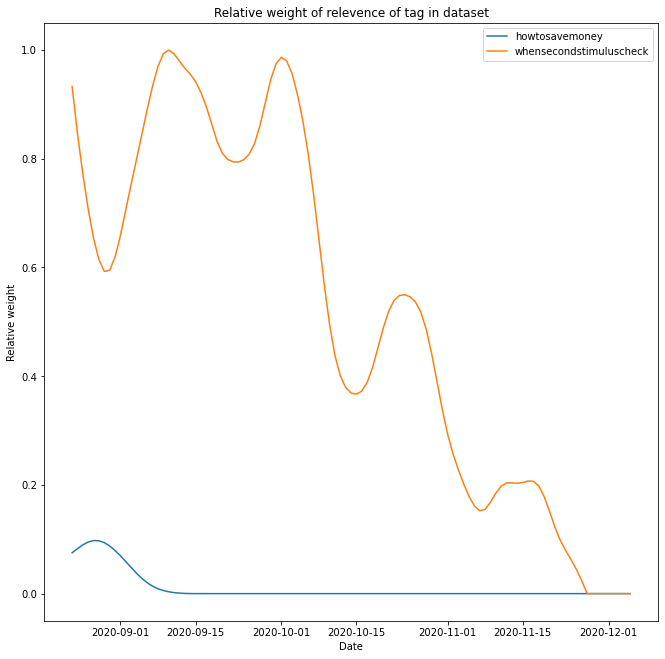

In [18]:
# Wow, these show an increadable amount of grouping
compair_tags('howtosavemoney', 'whensecondstimuluscheck')

In [21]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data

np.random.seed(0)


In [22]:
comarison_x = result_table.fillna(0).to_numpy() + result_table.fillna(0).T.to_numpy()
X = comarison_x
X.shape

(100, 100)

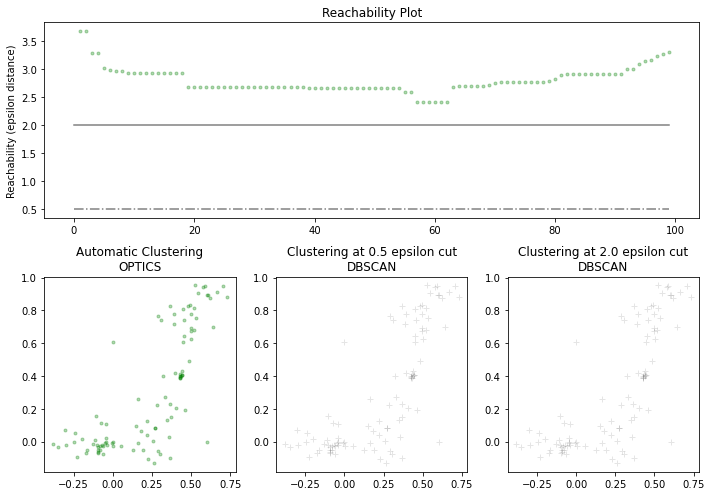

In [23]:
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()